In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Activation, BatchNormalization,
                                     Convolution1D, Dense, Flatten,
                                     Input)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight

In [20]:
windows_file = "/Users/lsantuari/Documents/Projects/GTCG/sv-channels/sv-channels_manuscript/DeepLift/HG00420_windows_en.npz"

In [29]:
import numpy as np
npzfile = np.load(windows_file, allow_pickle=True)
X = npzfile['data']
labels = npzfile['labels']
labels = labels.item()

svtype = 'DEL'
mapclasses = {svtype: 0, 'no' + svtype: 1}
y = np.array([mapclasses[i] for i in labels.values()])
y_binary = to_categorical(y, num_classes=len(mapclasses.keys()))

classes = np.array(np.unique(y))
y_lab = np.asarray(y)
class_weights = compute_class_weight('balanced', classes, y_lab)
class_weights = {i: v for i, v in enumerate(class_weights)}

/Users/lsantuari/Applications/Programming/mambaforge/envs/jupyterlab/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 0 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [42]:
shape = X.shape[0:]
outputdim = 2

filters = 8#16
layers = 1
kernel_size = 8
fc_nodes = 6#10
learning_rate = 1e-04
regularization_rate = 1.82357428e-04

In [43]:
def create_model(shape, outputdim, learning_rate, regularization_rate,
                 filters, layers, kernel_size, fc_nodes):
    weightinit = 'lecun_uniform'  # weight initialization

    model = Sequential()

    model.add(BatchNormalization(input_shape=(shape[1], shape[2])))

    filters_list = [filters] * layers

    for filter_number in filters_list:
        model.add(
            Convolution1D(filter_number,
                          kernel_size=(kernel_size,),
                          padding='same',
                          kernel_regularizer=l2(regularization_rate),
                          kernel_initializer=weightinit))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    model.add(Flatten())

    model.add(
        Dense(units=fc_nodes,
              kernel_regularizer=l2(regularization_rate),
              kernel_initializer=weightinit))  # Fully connected layer
    model.add(Activation('relu'))  # Relu activation

    model.add(Dense(units=outputdim, kernel_initializer=weightinit))
    model.add(BatchNormalization())
    model.add(Activation("softmax"))  # Final classification layer

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])

    return model

In [44]:
model = create_model(shape, outputdim, learning_rate, regularization_rate,
                 filters, layers, kernel_size, fc_nodes)

In [45]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

callbacks = [earlystop]

In [50]:
history = model.fit(x=X, y=y_binary,
                        epochs=50, batch_size=32,
                        shuffle=True,
                        validation_split=0.3,
                        class_weight=class_weights,
                        verbose=1)

Epoch 1/50
170/170 [==============================] - 19s 112ms/step - loss: 0.1706 - accuracy: 0.9741 - val_loss: 0.4844 - val_accuracy: 0.7924
Epoch 2/50
170/170 [==============================] - 14s 82ms/step - loss: 0.1600 - accuracy: 0.9772 - val_loss: 0.4952 - val_accuracy: 0.7906
Epoch 3/50
170/170 [==============================] - 14s 80ms/step - loss: 0.1524 - accuracy: 0.9807 - val_loss: 0.3887 - val_accuracy: 0.8481
Epoch 4/50
170/170 [==============================] - 14s 82ms/step - loss: 0.1423 - accuracy: 0.9855 - val_loss: 0.3833 - val_accuracy: 0.8507
Epoch 5/50
170/170 [==============================] - 14s 84ms/step - loss: 0.1406 - accuracy: 0.9853 - val_loss: 0.3388 - val_accuracy: 0.8876
Epoch 6/50
170/170 [==============================] - 14s 81ms/step - loss: 0.1289 - accuracy: 0.9893 - val_loss: 0.3807 - val_accuracy: 0.8563
Epoch 7/50
170/170 [==============================] - 14s 83ms/step - loss: 0.1200 - accuracy: 0.9915 - val_loss: 0.4004 - val_accuracy

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

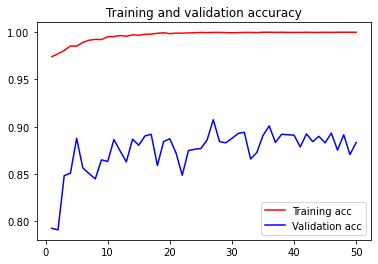

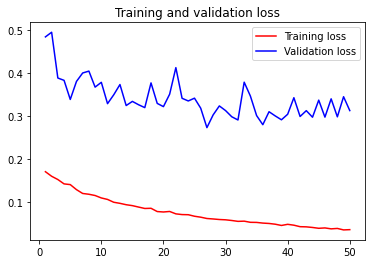

In [52]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()